In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (8, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

C:\Users\HARSH\Anaconda3\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# train = train_data
# test  = test_data
# Xtrain = train of training data
# Ytrain = target value of training data
# Xtest = test of training data
# Ytest = target value of test data
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

In [5]:
train = pd.read_csv('modified_train.csv', parse_dates=['Day.Index'], dayfirst=True)
test = pd.read_csv('modified_test.csv', parse_dates=['Day.Index'], dayfirst=True)
data = pd.read_csv('modified_data.csv', parse_dates=['Day.Index'], dayfirst=True)
ss = pd.read_csv('samplesubmission.csv')

In [6]:
train.columns,test.columns

(Index(['Day.Index', 'Campaign', 'Impressions', 'Target.Clicks', 'Obt.Click',
        'Min.CPC', 'Max.CPC', 'CTR', 'Amount.Spend', 'Returning.Users',
        'Targeted.Leads', 'SpecialDay', 'Avg. Bounce.Rate', 'Avg.Time.Page',
        'Avg.Position', 'Total.Revenue', 'Obtained.Leads', 'Year', 'Month',
        'Week', 'Day_Of_Week', 'Day', 'Day_Of_Year'],
       dtype='object'),
 Index(['Day.Index', 'Campaign', 'Impressions', 'Target.Clicks', 'Obt.Click',
        'Min.CPC', 'Max.CPC', 'CTR', 'Amount.Spend', 'Returning.Users',
        'Targeted.Leads', 'SpecialDay', 'Avg. Bounce.Rate', 'Avg.Time.Page',
        'Avg.Position', 'Total.Revenue', 'Year', 'Month', 'Week', 'Day_Of_Week',
        'Day', 'Day_Of_Year'],
       dtype='object'))

In [7]:
#Preparing data
def prepare_data(df, is_train):
    df_month = pd.get_dummies(df['Month'], prefix='month')
    df = pd.concat([df, df_month], axis=1)
    
    df_campaign = pd.get_dummies(df['Campaign'], prefix='campaign')
    df = pd.concat([df, df_campaign], axis=1)
    
    if is_train:
        return df.drop(['Obtained.Leads','Day.Index',"Campaign","Target.Clicks"], axis=1), df['Obtained.Leads']
    return df.drop(['Day.Index',"Campaign","Target.Clicks"], axis=1)

In [9]:
#Splitting Data
train_train_data = train[(train["Year"]==2013) |((train["Year"]==2014) & (train["Month"]<4))]
test_train_data = train[(train["Year"]==2015) |((train["Year"]==2014) & (train["Month"]>3))]

In [42]:
train,target_train=prepare_data(train,1)
test=prepare_data(test,0)
Xtrain, Ytrain=prepare_data(train_train_data,1)
Xtest, Ytest=prepare_data(test_train_data,1)

In [13]:
train_train_data.shape,test_train_data.shape,train.shape

((455, 23), (365, 23), (820, 23))

In [14]:
#Decision trees

In [49]:
import sklearn
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

In [50]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print ("BEST", gs.best_score_,gs.best_params_)
    best = gs.best_estimator_
    return best

In [54]:
parameters = {"max_depth": list(range(1,20)), 'min_samples_leaf': list(range(1,20))}
RegTree1 = tree.DecisionTreeRegressor()
clf = cv_optimize(RegTree1, parameters, Xtrain, Ytrain, n_jobs=4, n_folds=5)
clf=clf.fit(Xtrain, Ytrain)
training_accuracy = mean_squared_error(Ytrain, clf.predict(Xtrain))
test_accuracy =  mean_squared_error(Ytest, clf.predict(Xtest))

print ("############# based on standard predict ################")
print ("Accuracy on training data: %0.2f" % (training_accuracy))
print ("Accuracy on test data:     %0.2f" % (test_accuracy))
print ("########################################################")

BEST 0.529160276728 {'max_depth': 8, 'min_samples_leaf': 4}
############# based on standard predict ################
Accuracy on training data: 3.19
Accuracy on test data:     13.48
########################################################


In [ ]:
Analyzing the different parameters of Decision Trees.

In [1]:
plt.figure(figsize=(15,7))

# #Max Features
#plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
b=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(max_features=feature)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
    b.append(mean_squared_error(Ytest, clf.predict(Xtest)
fig = plt.figure()
ax1 = fig.add_subplot(231)
ax1.plot(scores, c='b',label='training')
ax1.plot(b, c='r', label='test')
plt.axis('tight')
plt.legend(loc='upper left');
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.show();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
b=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(max_depth=feature)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
ax2 = fig.add_subplot(232)
plt.plot(feature_param,scores, c='b',label='training')
plt.plot(feature_param,b, c='r', label='test')
plt.axis('tight')
plt.legend(loc='upper left');
plt.title('Max Depth')
plt.show();



# #Min Samples Split
# feature_param = range(1,51)
# ax2 = fig.add_subplot(232)
# func(feature_param,ax2,"min_samples_split")

# #Min Samples Leaf
# feature_param = range(1,51)
# ax3 = fig.add_subplot(233)
# func(feature_param,ax3,"min_samples_leaf")

# #Min Weight Fraction Leaf
# feature_param = np.linspace(0,0.5,10)
# ax4 = fig.add_subplot(234)
# func(feature_param,ax4,"min_weight_fraction_leaf")


# #Max Leaf Nodes
# feature_param = np.linspace(0,0.5,10)
# ax5 = fig.add_subplot(235)
# func(feature_param,ax5,"max_leaf_nodes")

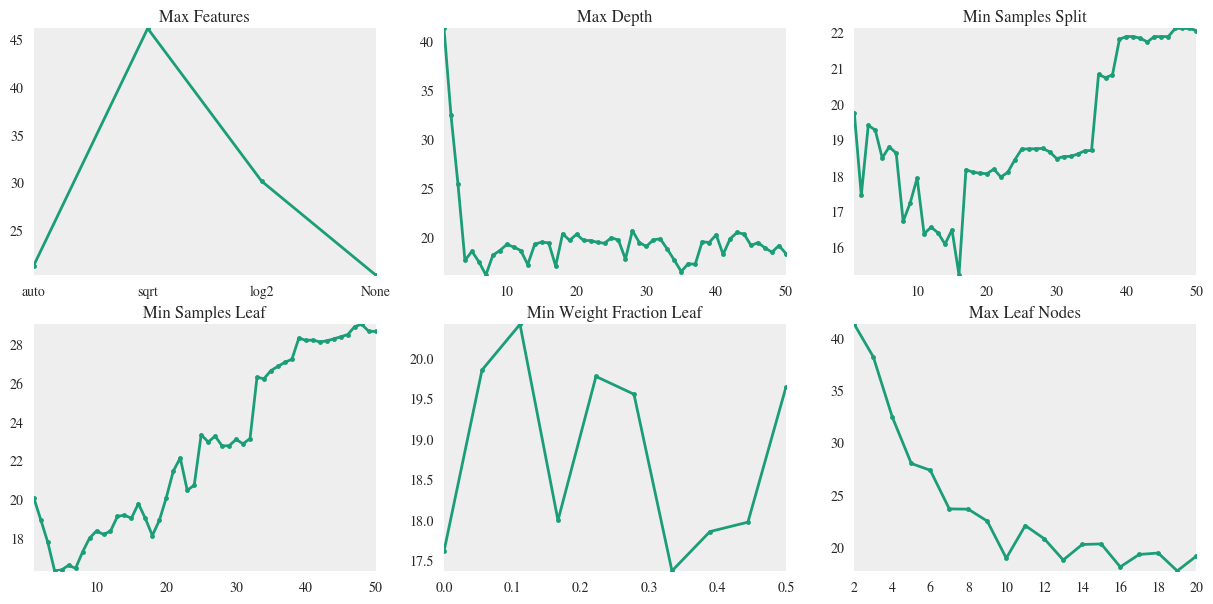

In [60]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(max_features=feature)
    clf.fit(Xtrain,Ytrain)
    
    
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(max_depth=feature)
    clf.fit(Xtrain,Ytrain)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))

    
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(min_samples_split=feature)
    clf.fit(Xtrain,Ytrain)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(min_samples_leaf=feature)
    clf.fit(Xtrain,Ytrain)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(min_weight_fraction_leaf=feature)
    clf.fit(Xtrain,Ytrain)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = tree.DecisionTreeRegressor(max_leaf_nodes=feature)
    clf.fit(Xtrain,Ytrain)
    from sklearn.cross_validation import KFold
    a=[]
    for train, test in KFold(len(ytrain),5):
        clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
        a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))
    scores.append(np.mean(a))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

In [11]:
from sklearn.cross_validation import KFold
a=[]
for train, test in KFold(len(ytrain),5):
    clf = LinearRegression()
    clf.fit(xtrain.iloc[train], ytrain.iloc[train]) # fit
    a.append(mean_squared_error(ytrain.iloc[test], clf.predict(xtrain.iloc[test])))

In [12]:
a

[5.1718096437035692,
 6.1968150870458851,
 6.8166125992765956,
 36.015657918426662,
 6.9299201947405367]

In [13]:
est = LinearRegression()
est.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
prediction_on_test = est.predict(xtest)
print ("test_error  "+ str(mean_squared_error(ytest, prediction_on_test)))

test_error  5.68270066396


In [15]:
#Ridge Regression

In [16]:
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1,.3,.5,.7, 1.0,10,100,1000,10000]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [17]:
fitmodel = cv_optimize_ridge(xtrain,ytrain, n_folds=4)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 {'alpha': 100},
 -6.9151612289139042,
 [mean: -7.44278, std: 2.33611, params: {'alpha': 1e-08},
  mean: -7.44307, std: 2.33616, params: {'alpha': 1e-06},
  mean: -7.44307, std: 2.33616, params: {'alpha': 1e-05},
  mean: -7.44306, std: 2.33615, params: {'alpha': 5e-05},
  mean: -7.44306, std: 2.33614, params: {'alpha': 0.0001},
  mean: -7.44302, std: 2.33609, params: {'alpha': 0.0005},
  mean: -7.44297, std: 2.33602, params: {'alpha': 0.001},
  mean: -7.44213, std: 2.33473, params: {'alpha': 0.01},
  mean: -7.43418, std: 2.32254, params: {'alpha': 0.1},
  mean: -7.41917, std: 2.29898, params: {'alpha': 0.3},
  mean: -7.40664, std: 2.27877, params: {'alpha': 0.5},
  mean: -7.39573, std: 2.26078, params: {'alpha': 0.7},
  mean: -7.38136, std: 2.23658, params: {'alpha': 1.0},
  mean: -7.14574, std: 1.79931, params: {'alpha': 10},
  mean: -6.91516, std: 0.991

In [18]:
alphawechoose = fitmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(xtrain,ytrain)
prediction_on_training = clf.predict(xtrain)
prediction_on_test = clf.predict(xtest)
print ("training_error  " + str(mean_squared_error(ytrain, prediction_on_training)))
print ("test_error  "+ str(mean_squared_error(ytest, prediction_on_test)))

training_error  5.87298245032
test_error  5.58498617235


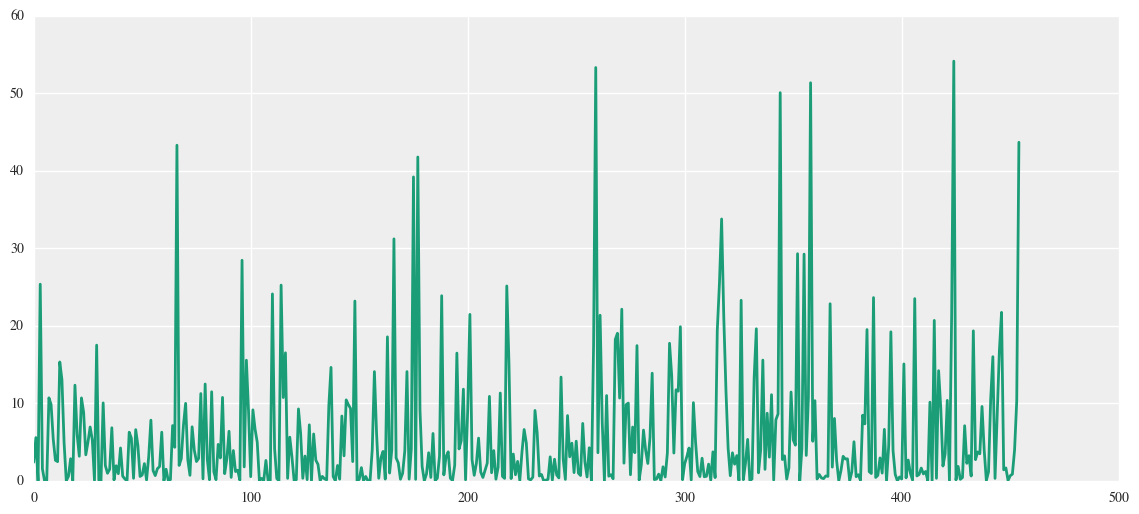

In [23]:
rcParams['figure.figsize'] = (14, 6)
plt.plot(xtrain.index, (prediction_on_training-ytrain)**2)

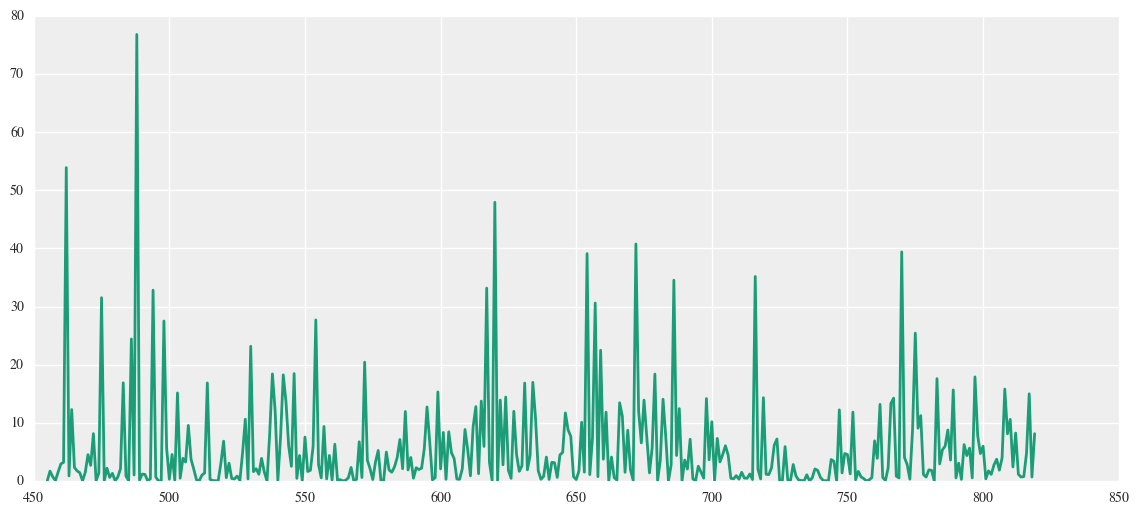

In [19]:
rcParams['figure.figsize'] = (14, 6)
plt.plot(xtest.index, (prediction_on_test-ytest)**2)

In [20]:
#applying on full data

In [3]:
train,target_train=prepare_data(train,1)
test=prepare_data(test,0)
clf = Ridge(alpha=alphawechoose).fit(train,target_train)
prediction = clf.predict(test)

In [ ]:
prediction[0:5]

In [ ]:
predicted = np.round(prediction, decimals=0).astype(int)
predicted[0:5]

In [ ]:
solution = pd.DataFrame(ss['Day.Index'])
solution = pd.concat([solution, pd.DataFrame(predicted, columns=['Obtained.Leads'])], axis=1)

In [ ]:
solution.head()

In [ ]:
path='C:\\Users\\HARSH\\Desktop\\Data_Tales\\Submit\\'
solution.to_csv(path+r'Linear_Ridge.csv', index=False)

In [ ]:
#no